##Preprocessing Tweets

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [12]:
import torch
import pandas as pd
labeled_data = pd.read_csv('/content/drive/MyDrive/DATA_NLP/labeled_data.csv')
data = labeled_data[["class", "tweet"]]
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [27]:
labeled_data = 0

In [14]:
pip install pytorch-transformers 

     |████████████████████████████████| 184kB 8.6MB/s 
     |████████████████████████████████| 890kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 26.0MB/s 
     |████████████████████████████████| 133kB 54.4MB/s 
     |████████████████████████████████| 7.2MB 49.5MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=22000e8ce1ef0f9218396c5c21b10951d9a16dc72a7cfa2f16da93f058074159
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.20.10 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [15]:
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer 
import re
stopwords_english = stopwords.words('english')
import string
punctuations = string.punctuation


def processing_tweets(tweet):
  tweet2 = re.sub(r'RT[\s]+', '', tweet)# remove old style retweet text "RT"
  tweet2 =re.sub(r'https?:\/\/?[\da-z\.-]+\.[a-z\.]{2,6}[\/\w\.-]*', '', tweet2)# remove hyperlinks
  tweet2 = re.sub(r'#','',tweet2) # remove hashtags，only removing the hash # sign from the word
  tweet2 = re.sub(r'[0-9]+',' ', tweet2)
  tweet2 = re.sub(r'[.,\/#!$%\^&\*;:{}=\-_`~()]+', '', tweet2)  # remove punctuations from the word


  #tweet2 = "[CLS] " + tweet2 + " [SEP]"
  #tweet_tokens = tokenizer.tokenize(tweet2) #tokenizing the tweet
  tweet_tokens = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False).tokenize(tweet2) #tokenizing the tweet

  tweet_clean = []
  for word in tweet_tokens:
    if(word not in stopwords_english and word not in punctuations): #remove stopwords and punctuations
      tweet_clean.append(word)

  tweet_stemed = []

  for word in tweet_clean:
    if word[0]!='@' and word[0] not in punctuations:
      word_stemed = WordNetLemmatizer().lemmatize(word) #stem the words
      tweet_stemed.append(word_stemed)

  text = ""
  for word in tweet_stemed:
    text+=word
    text+=" "

  text = "[CLS] " + text + " [SEP]"


  return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [16]:
import torch
from pytorch_transformers import BertTokenizer
from  pytorch_transformers import BertModel
## Load pretrained model/tokenizer
tokenizer1 = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)


100%|██████████| 440473133/440473133 [00:12<00:00, 35374658.50B/s]


In [17]:
##Generate corpus
import torch
import numpy

def Generate_Word_Embeddings(n = len(data['tweet'])):
  corpus = []
  ids = []
  for i in range(n): #range(len(data['tweet'])):
    sentence = processing_tweets(data["tweet"][i])
    sentence = tokenizer1.tokenize(sentence)
    for j in range(100-len(sentence)):
      sentence.append("")
    indexed_tokens = tokenizer1.convert_tokens_to_ids(sentence)
    corpus.append(sentence)
    ids.append(indexed_tokens)

  new_corpus = []
  new_ids = []
  new_tags = []
  for i in range(0, len(corpus)):
    if len(corpus[i])>0:
      new_corpus.append(corpus[i])
      new_ids.append(ids[i])
      new_tags.append(data["class"][i])

  # Convert inputs to PyTorch tensors
  token_tensors = []
  for indexed_tokens in new_ids:
    tokens_tensor = torch.tensor([indexed_tokens])
    token_tensors.append(tokens_tensor)
  # Put the model in "evaluation" mode,meaning feed-forward operation.
  model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
  model.eval()

  word_embeddings = []
  with torch.no_grad():
    for tokens_tensor in token_tensors:
      outputs = model(tokens_tensor)
  # can use last hidden state as word embeddings
      last_hidden_state = outputs[0]
      word_embeddings.append(last_hidden_state)#.detach().numpy())
      #word_embeddings = np.stack(word_embeddings, axis=0)
      #word_embeddings = torch.from_numpy(word_embeddings)

  return word_embeddings


##Save numpy word embeddings to pt

In [ ]:
def generate_and_save_wv(file_name = 'hate_speech_wv', n = 1):
  path = '/content/drive/MyDrive/DATA_NLP/'
  path = path+file_name
  path = path+'.pt'
  word_embeddings = Generate_Word_Embeddings(n)
  x = []
  for i in word_embeddings:
    n = i.detach().numpy()
    x.append(n)

  x = np.stack(x, axis = 0)
  x = torch.from_numpy(x)
  x = torch.squeeze(x)
  torch.save(x, path)


In [18]:
# Save to file
word_embeddings = Generate_Word_Embeddings()



In [19]:
len(word_embeddings)

24783

In [21]:
import numpy as np

x = []
for i in word_embeddings:
  n = i.detach().numpy()
  x.append(n)

x = np.stack(x, axis = 0)
x = torch.from_numpy(x)
x = torch.squeeze(x)


In [22]:
x.shape

torch.Size([24783, 100, 768])

In [23]:
torch.save(x, '/content/drive/MyDrive/DATA_NLP/hst.pt')

##Start from here


In [24]:
import torch
t = torch.load('/content/drive/MyDrive/DATA_NLP/hst.pt')#, map_location=torch.device('cpu'))
t.shape

torch.Size([24783, 100, 768])

In [30]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/DATA_NLP/hsdata.csv') 

In [32]:
data = data[['class', 'tweet']]
data.dtypes

class     int64
tweet    object
dtype: object

In [33]:
target = []
for i in range(len(data['class'])):
  target.append(data['class'][i])

target = torch.tensor(target)

target

tensor([2, 1, 1,  ..., 1, 1, 2])

In [34]:
X = t.detach().numpy()
y = target.detach().numpy()

In [35]:
print(y.shape)
print(X.shape)

(24783,)
(24783, 100, 768)


In [36]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [39]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y 

  def __len__(self):
        'Denotes the total number of samples'
        return self.x.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        X = self.x[index]
        y = self.y[index]

        return X, y


In [67]:
tweet_data_train = Dataset(torch.from_numpy(X_train[0:18500]).to(device), torch.from_numpy(y_train[0:18500]).to(device))
tweet_data_test = Dataset(torch.from_numpy(X_test[0:6100]).to(device), torch.from_numpy(y_test[0:6100]).to(device))

In [68]:
print(tweet_data_train.x.device)

cuda:0


In [42]:
len(tweet_data_test)

6100

In [69]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=tweet_data_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=tweet_data_test, batch_size=100, shuffle=True)


##Convolution/LSTM Classifier


In [72]:
import torch.nn as nn
import torch.functional as F
class Convo_Lstm(nn.Module):
  def __init__(self):
    super(Convo_Lstm, self).__init__()
    self.layer1 = nn.Conv1d(768, 100, 1, stride=1).cuda()
    self.pooling1 = nn.MaxPool1d(2, stride=2)
    self.layer2 = nn.LSTM(100, 16, 1).cuda()
    self.h0 = torch.randn(1, 100, 16).cuda()
    self.c0 = torch.randn(1, 100, 16).cuda()
    self.layer3 = nn.Linear(16, 3).cuda()
    self.dummy_param = nn.Parameter(torch.empty(0))

  def forward(self, x):
    x = x.permute(1,2,0)
    x = self.layer1(x)
    x = nn.functional.relu(x)
    x = x.permute(0, 2, 1)
    output_1, (hn, cn) = self.layer2(x, (self.h0, self.c0))
    out = self.layer3(hn)
    return out




In [97]:
def training(model0):
  loss_l = []
  criterion = nn.CrossEntropyLoss()
  model = model0
  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, weight_decay=0.001)

  for epoch in range(150):
    optimizer.zero_grad
    n = 0
    l = 0
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        yhat = model(x_batch)
        loss = criterion(torch.squeeze(yhat), y_batch)
        loss.backward()
        optimizer.step()
        l = l + loss
        n = n+1
    loss_l.append(l/n)

  return model, loss_l

model, l = training()

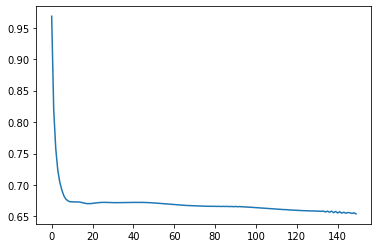

In [98]:
import matplotlib.pyplot as plt
plt.plot(l)

##Evaluate

In [104]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

acc = 0
f1 = 0
roc_auc = 0
pred = []
true = []
for x_batch, y_batch in test_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        yhat = model0(x_batch)
        arg = torch.squeeze(yhat)
        ypred = torch.argmax(arg, dim = 1).to('cpu').detach().numpy()
        pred.append(ypred)
        ytrue = y_batch.to('cpu').detach().numpy()
        true.append(ytrue)
        acc+=accuracy_score(ytrue, ypred)
        f1+=f1_score(ytrue, ypred, average='macro')
        #roc_auc+=roc_auc_score(ytrue, ypred, average='macro')
print('acc = ', acc/(len(tweet_data_test)/100))
print('f1 = ', f1/(len(tweet_data_test)/100))
#print('roc = ', roc_auc/(len(tweet_data_test)/100))

acc =  0.7865573770491806
f1 =  0.29582913151149937


In [92]:
from sklearn.metrics import confusion_matrix


confusion_matrix(true, pred, normalize = 'true')



array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

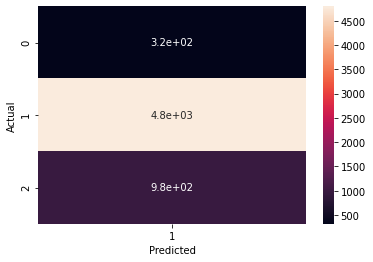

In [96]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':   true,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()


##Continue training

In [102]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DATA_NLP/hsrecognizer_0.pth')


In [109]:
model0 = Convo_Lstm()
model0.load_state_dict(torch.load('/content/drive/MyDrive/DATA_NLP/hsrecognizer_0.pth'))


<All keys matched successfully>

In [107]:
def training(model0, lr0=0.000005, weight_decay0=0.001, epochs=100):
  loss_l = []
  criterion = nn.CrossEntropyLoss()
  model = model0
  model.cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr0, weight_decay=weight_decay0)

  for epoch in range(epochs):
    optimizer.zero_grad
    n = 0
    l = 0
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        yhat = model(x_batch)
        loss = criterion(torch.squeeze(yhat), y_batch)
        loss.backward()
        optimizer.step()
        l = l + loss
        n = n+1
    loss_l.append(l/n)

  return model, loss_l


In [ ]:
model0, l1 =  training(model0, 0.00002, 0.001, epochs=50)

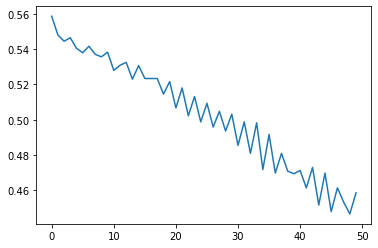

In [115]:
plt.plot(l1)

In [116]:
torch.save(model0.state_dict(), '/content/drive/MyDrive/DATA_NLP/hsrecognizer_0.pth')


In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

acc = 0
f1 = 0
roc_auc = 0
pred = []
true = []
for x_batch, y_batch in test_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        yhat = model0(x_batch)
        arg = torch.squeeze(yhat)
        ypred = torch.argmax(arg, dim = 1).to('cpu').detach().numpy()
        pred.append(ypred)
        ytrue = y_batch.to('cpu').detach().numpy()
        true.append(ytrue)
        acc+=accuracy_score(ytrue, ypred)
        f1+=f1_score(ytrue, ypred, average='macro')
        #roc_auc+=roc_auc_score(ytrue, ypred, average='macro')
print('acc = ', acc/(len(tweet_data_test)/100))
print('f1 = ', f1/(len(tweet_data_test)/100))
#print('roc = ', roc_auc/(len(tweet_data_test)/100))

acc =  0.8629508196721313
f1 =  0.5440864550128396


##Training Word2Vec

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [ ]:
model1 = Word2Vec(sentences=new_corpus, size=100, window=5, min_count=1, workers=4)

In [ ]:
import numpy as np
sentence_vectors1 = []
for tokens in new_corpus:
  temp = []
  for word in tokens:
    a = model1.wv[word]
    temp.append(a)
  temp = np.mean(temp, axis = 0)
  sentence_vectors1.append(temp)

len(sentence_vectors1)

for i in range(0, len(sentence_vectors1)):
  if sentence_vectors1[i].shape!=(100,):
    print(i)

sentence_vectors1 = np.array(sentence_vectors1)

In [ ]:
sentence_vectors1

array([[-0.07942008,  0.16807978,  0.63257915, ..., -0.3462815 ,
         0.15567617, -0.7950565 ],
       [-0.05953404,  0.17446929,  0.6993782 , ..., -0.3123042 ,
         0.1502066 , -0.8443284 ],
       [-0.08690218,  0.19759002,  0.7586323 , ..., -0.36930317,
         0.1729969 , -0.9154099 ],
       ...,
       [-0.03928775,  0.188493  ,  0.7972574 , ..., -0.32477093,
         0.16799062, -0.9810043 ],
       [-0.0425214 ,  0.16539967,  0.7238931 , ..., -0.3313654 ,
         0.1557964 , -0.90268505],
       [-0.04197668,  0.10084955,  0.4086026 , ..., -0.22133932,
         0.0987414 , -0.51935524]], dtype=float32)

In [ ]:
model.wv["complain"].shape

(100,)

##Generate sentence vectors

In [ ]:
import numpy as np

In [ ]:
for i in range(0, len(sentence_vectors)):
  if sentence_vectors[i].shape!=torch.Size([768]):
    print(i)

In [ ]:
training_set = []
for i in range(0, len(sentence_vectors)):
  training_set.append(sentence_vectors[i].numpy())

len(training_set)

24783

In [ ]:
training_set = np.array(training_set)

In [ ]:
training_set.shape

(24783, 768)

In [ ]:
a.shape

(24783, 100)

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
training_label = np.array(new_tags)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(training_set, training_label)


In [ ]:
training_set1 = sentence_vectors1
Xtrain1, Xtest1, Ytrain1, Ytest1 = train_test_split(training_set1, training_label, test_size=0.20)


In [ ]:
modelb = LogisticRegression(max_iter=1000)

In [ ]:
model1 = LogisticRegression(max_iter=1000)

In [ ]:
training_label.shape

(24783,)

In [ ]:
model.fit(Xtrain, Ytrain)

AttributeError: ignored

In [ ]:
model1.fit(Xtrain1, Ytrain1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
ymodel = model.predict(Xtest)

In [ ]:
ymodel1 = model1.predict(Xtest1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
confusion_matrix(Ytest, ymodel)

array([[  51,  246,   60],
       [  59, 4499,  206],
       [  11,  312,  752]])

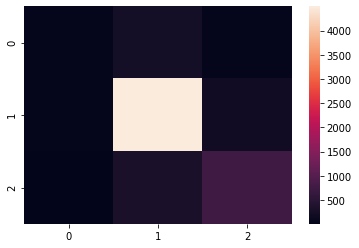

In [ ]:
sns.heatmap(confusion_matrix(Ytest, ymodel))

In [ ]:
from sklearn.model_selection import cross_val_score


In [ ]:
cross_val_score(model, training_set, training_label)

array([0.83619124, 0.83353511, 0.85209847, 0.86460856, 0.85411622])

In [ ]:
Xtest.shape[0]/Xtrain.shape[0]

0.33335126701458007

In [ ]:
from sklearn.metrics import f1_score
f1_score(Ytest, ymodel, average='macro')


0.6160582876794701

In [ ]:
from sklearn.metrics import f1_score
f1_score(Ytest1, ymodel1, average='macro')


0.5360106366682423

In [ ]:
from sklearn.metric import 
sklearn.metrics.auc(x, y)